In [17]:
import random
import scipy.stats as stats
from scipy.stats import binom
import json
import ast
import pandas as pd
import numpy
import copy
from operator import itemgetter, attrgetter, methodcaller
import itertools
import matplotlib.pyplot as pl
from docx import Document
from docx.text.run import Font, Run
from docx.dml.color import ColorFormat
from docx.shared import RGBColor
from scipy.stats import poisson
import math

'''
The multinomial CDF function is the implementation of Levin's "Representaion of Multinomial Cumulative Distribution Function"

G:= Number of total groups (including non-protected)
k:= Position
p:= Array of probabilities of each group to be selected
tau_p:= Array of number of protected items

EXAMPLE:
Groups: ["White"(NP), "Black"(P), "Asian"(P), "Hispanic"(P)]
k: 30
p: [0.4, 0.3, 0.2, 0.1]
tau_p: [k, 10, 5, 3]
The ranking is fair if multinomCDF(4, 30, p, tau_p) > a = 0.1 
'''

def multinomCDF_log(G, k, p, tau_p):
    s = float(k);
    log_cdf = -poisson.logpmf(k,s);
    gamma1 = 0.0;
    gamma2 = 0.0;
    sum_s2 = 0.0;
    sum_mu = 0.0;
    
    # P(W=k)
    for i in range(0,G):
        sp = s*p[i];
        
        pcdf = poisson.cdf(tau_p[i],sp);
        log_cdf += numpy.log(pcdf);
        
        mu = sp*(1-poisson.pmf(tau_p[i],sp)/pcdf);
        s2 = mu-(tau_p[i]-mu)*(sp-mu);
        
        mr = tau_p[i];
        mf2 = sp*mu-mr*(sp-mu);
        
        mr *= tau_p[i]-1;
        mf3 = sp*mf2-mr*(sp-mu);
        
        mr *= tau_p[i]-2;
        mf4 = sp*mf3-mr*(sp-mu);
        
        mu2 = mf2+mu*(1-mu);
        mu3 = mf3+mf2*(3-3*mu)+mu*(1+mu*(-3+2*mu));
        mu4 = mf4+mf3*(6-4*mu)+mf2*(7+mu*(-12+6*mu))+mu*(1+mu*(-4+mu*(6-3*mu)));
        
        gamma1 += mu3;
        gamma2 += mu4-3*s2*s2;
        sum_mu += mu;
        sum_s2 += s2; 
    sp = numpy.sqrt(sum_s2);
    gamma1 /= sum_s2*sp;
    gamma2 /= sum_s2*sum_s2;
    
    x = (k-sum_mu)/sp;
    x2 = x*x;
    
    PWN = (-x2/2
    +numpy.log(1+gamma1/6*x*(x2-3)+gamma2/24*(x2*x2-6*x2+3)
    +gamma1*gamma1/72*(((x2-15)*x2+45)*x2-15))
    -numpy.log(2*math.pi)/2 -numpy.log(sp));
    
    log_cdf += PWN;
    return log_cdf;

def multinomCDF(G, k, p, tau_p):
    return numpy.exp(multinomCDF_log(G, k, p, tau_p ));

"""
To find a continuous multinomial icdf solution from a solution space.
Used for the Ranking Algorithm.
If the multinomial_CDF with tau alreay results in the value > a, return tau.
Else calculate the multinomial_CDF of tau in each case when each element of tau is increased by 1.
Compare the value and take the tau that produces the closest multinomial_CDF to a, which is also > a.

For example, initial tau: [0, 0, 0, 0]
if: 
    multinomial_CDF(G, k, p, tau) > a, return tau
else:
    compare:
        multinomial_CDF(G, k, p, [1, 0, 0, 0])
        multinomial_CDF(G, k, p, [0, 1, 0, 0])
        multinomial_CDF(G, k, p, [0, 0, 1, 0])
        multinomial_CDF(G, k, p, [0, 0, 0, 1])
    and take the increased tau with its multinomial_CDF > a and closest to a    

"""
def multinomial_icdf_continuous(G, k, p, a, tau):
    tau_p = [k] + list(tau);
    temp = copy.copy(tau_p)
    cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    
    if(cdf > a):
        return tau_p;
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf >= a and new_cdf >= cdf):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p); 
        if(new_cdf >= a or cdf >= a):
            temp[i+1] = temp[i+1]-1    
    return tau_p

"""
Finds the target group which does not achieve the minimum target.
"""
def find_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] > count[i+1]):
                return categories[i+1];  

def find_achieved_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] < count[i+1]):
                return categories[i+1];        
            
"""
    - data_set: list of items in dictionary form, which specifies its group and quality
        ex) 
        [{'Gender': 0, 'Uni score': 0.5344585435},
         {'Gender': 2, 'Uni score': 1.0160173543},
         {'Gender': 0, 'Uni score': 0.4573686375},
         {'Gender': 1, 'Uni score': 0.6513702354}]
         
    - attributeNamesAndCategories: attributes that are being used to specify groups in the data_set and its number of categories
        ex)
        {"Gender": 4}
    
    - attributeQuality: the name of the attribute used for quality
        ex)
        "Uni score"
        
    - k: total length of the ranking
    
    - p: array of prbability, that each group could be selected into the ranking
        ex)
        [0.4,0.3,0.2,0.1]
            -> 0.4 for Gender: 0 (Non-protected)
            -> 0.3 for Gender: 1 (Protected)
            -> 0.2 for Gender: 2 (Protected)
            -> 0.1 for Gender: 3 (Protected)
            
    - alpha: Percentage of Type I error            
"""
def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups

def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p[1:]
    df.index = numpy.array(range(k))+1
    df.to_html("minimum_target_table.html")    
    return minimum_targets    

def get_minimum_targets_binom(p, alpha, k):
    minimum_targets = [];
    p_np = p[1:]
    
    for i in range(k):
        mt = []
        for p_j in p_np:
            mt.append(binom.ppf(alpha, i+1, p_j))
        minimum_targets.append(mt)   
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p_np
    df.index = numpy.array(range(k))+1
    df.to_html("binomial2Multinomial_"+str(p)+".html")    
    return minimum_targets 

def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen']
    markers = ['-o','-<','-s','-+', '-d', '-x', '-h', '-p']
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
#     label=['Male-married','Male-single','Male-divorced','Female']
#     label=['German','Turkish','Yugoslavian','Greek','Italian']
#     label=['German','Other','Asylum','EU Country']
#     label=['Male single','Female divorced/separated/married','Male divorced/separated','Male married/widowed']


    best = data_set[0][attributeQuality]
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = pl.figure(figsize=(20, 10))
    pl.subplot(211)
    round_2f = []
    for k in data_set:
        k[attributeQuality] = float(k[attributeQuality])/best
    
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i]))  
        pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=categories[i], color=colors[i])
#         pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=label[i], color=colors[i])
        pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
        round_2f.append([round(elem, 2) for elem in separateQualityByGroups[i]])
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Probability Density Function')

    pl.subplot(212)
    pl.hist(round_2f,30, histtype='bar', label=categories, color=colors[:len(categories)])    
#     pl.hist(round_2f,30, histtype='bar', label=label, color=colors[:len(categories)])    
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Frequency')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()
    
def plot_scatter(data_set,attributeNamesAndCategories, attributeQuality):
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
#     label=['Male-married','Male-single','Male-divorced','Female']
#     label=['German','Turkish','Yugoslavian','Greek','Italian']
#     label=['German','Other','Asylum','EU Country']
#     label=['Male single','Female divorced/separated/married','Male divorced/separated','Male married/widowed']
   
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen']
    markers = ['o','<','s','>', 'd', 'x', 'h', 'p']
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    separateQualityByGroups = []
    positionByGroups =[]
    for i in range(len(data_set)):
        data_set[i]['k']=i+1
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)       
    fig = pl.figure(figsize=(6, 6), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        positionByGroups.append([k['k'] for k in output_ranking_separated[i]])
        area = numpy.pi*4
        pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=categories[i], marker=markers[i])
#         pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=label[i], marker=markers[i])    
    pl.xlabel('Position (k)')
    pl.ylabel(attributeQuality+' (Quality)')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
#     pl.ylim(0, 6.0)
    pl.show()       
    
def generate_ranking(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind):
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ()
    attributeItems = attributeNamesAndCategories.items()
    fileName = str(p)+'_'+str(k)
    
    if(color_blind):
        fileName = fileName+'_cb'
    
    no_remaining_items = 0
        
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]
    
    f = open('ranking_'+fileName+'.txt', 'w')
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    if(color_blind):
        minimum_targets = numpy.zeros((k,num_categories-1))
    else:
        minimum_targets = get_minimum_targets(categories, p, alpha, k)
    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                if(len(separateByGroups[j+1]) == 0):
                    no_remaining_items = 1
                    break
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                f.write(str(item)+"\n")
                count[j+1] += 1;
                chosen = 1;
                print item
                if(any(count[a+1]<i[a] for a in range(len(i)))):
                    swap = len(ranking)-1;
                    print"-------------------------------------------"
                    print minimum_targets
                    while(any(count[a+1]<i[a] for a in range(len(i)))):
                        target = find_target(i, count, categories);
                        if(count[0] == 0):
                            achieved_target = find_achieved_target(i, count, categories);
                            if (all(ranking[swap][attributes[i]] == achieved_target[i] for i in range(len(attributes)))):
                                print ranking[swap]
                                separateByGroups[categories.index(achieved_target)].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[categories.index(achieved_target)] -= 1
                        else:    
                            print target
                            if (all(ranking[swap][a] == 0 for a in attributes)):
                                separateByGroups[0].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[0] -= 1;
                        swap -= 1;    
                print "Minimum achieved? ", all(count[a+1]>=i[a] for a in range(len(i)))
        if(no_remaining_items == 1):
            break
        if(chosen == 0):
            heads = []
            for x in separateByGroups:
                if (len(x) == 0):
                    heads.append(-100)                 
                else:
                    heads.append(x[len(x)-1][attributeQuality])                 
            idx= heads.index(max(heads))
            item = separateByGroups[idx].pop()
            print item
            f.write(str(item)+"\n")
            ranking.append(item);
            count[idx] += 1;
        print num, ": ", count, "Minimum Target: ",minimum_targets[num-1];
        f.write(str(num)+": "+str(count)+"Minimum Target: "+str(minimum_targets[num-1])+"\n")
        print "CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:])
        f.write("CDF: "+str(multinomCDF(num_categories, num, p, [num]+count[1:]))+"\n")
        num = num+1;
        chosen = 0;
    f.close()    
    rest = []
    best = ranking[0][attributeQuality]
    for i in separateByGroups:
        for j in i:
            rest.append(float(j[attributeQuality])/float(best))
    plot_scatter(ranking,attributeNamesAndCategories, attributeQuality)
    plot(ranking,attributeNamesAndCategories, attributeQuality)
    for q in range(len(ranking)):
        ranking[q]['k']=q+1
        ranking[q]['Utility'] = (1.0/numpy.log(1+ q+1))*ranking[q][attributeQuality]
    if(num_categories <=7):
        document = Document()
        document.add_heading("Output Ranking", 0)

        for idx in range(len(ranking)):
            if (all(ranking[idx][attributes[i]] == categories[0][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x3f, 0x2c, 0x36)
                print("\033[1;30m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[1][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xcc, 0x00, 0x00)
                print("\033[1;31m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[2][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x66, 0xff)
                print("\033[1;34m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[3][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x99, 0x33)
                print("\033[1;32m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[4][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xFF, 0xCC, 0x33)
                print("\033[1;33m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[5][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x99, 0x66, 0x00)
                print("\033[1;35m%s\033[1;m") % ranking[idx]  
            elif (all(ranking[idx][attributes[i]] == categories[6][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;37m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[7][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;41m%s\033[1;m") % ranking[idx]    
        document.save('output_ranking.docx')
        
    return ranking, rest

def generate_ranking_from_binom(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind):
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ()
    attributeItems = attributeNamesAndCategories.items()
    fileName = str(p)+'_'+str(k)
    
    if(color_blind):
        fileName = fileName+'_cb'
    
    no_remaining_items = 0
        
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]
    
    f = open('ranking_'+fileName+'.txt', 'w')
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    if(color_blind):
        minimum_targets = numpy.zeros((k,num_categories-1))
    else:
        minimum_targets = get_minimum_targets_binom(p, alpha, k)    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                if(len(separateByGroups[j+1]) == 0):
                    no_remaining_items = 1
                    break
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                f.write(str(item)+"\n")
                count[j+1] += 1;
                chosen = 1;
                print item
                if(any(count[a+1]<i[a] for a in range(len(i)))):
                    swap = len(ranking)-1;
                    print"-------------------------------------------"
                    print minimum_targets
                    while(any(count[a+1]<i[a] for a in range(len(i)))):
                        target = find_target(i, count, categories);
                        if(count[0] == 0):
                            achieved_target = find_achieved_target(i, count, categories);
                            if (all(ranking[swap][attributes[i]] == achieved_target[i] for i in range(len(attributes)))):
                                print ranking[swap]
                                separateByGroups[categories.index(achieved_target)].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[categories.index(achieved_target)] -= 1
                        else:    
                            print target
                            if (all(ranking[swap][a] == 0 for a in attributes)):
                                separateByGroups[0].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[0] -= 1;
                        swap -= 1;    
                print "Minimum achieved? ", all(count[a+1]>=i[a] for a in range(len(i)))
        if(no_remaining_items == 1):
            break
        if(chosen == 0):
            heads = []
            for x in separateByGroups:
                if (len(x) == 0):
                    heads.append(-100)                 
                else:
                    heads.append(x[len(x)-1][attributeQuality])                 
            idx= heads.index(max(heads))
            item = separateByGroups[idx].pop()
            print item
            f.write(str(item)+"\n")
            ranking.append(item);
            count[idx] += 1;
        print num, ": ", count, "Minimum Target: ",minimum_targets[num-1];
        f.write(str(num)+": "+str(count)+"Minimum Target: "+str(minimum_targets[num-1])+"\n")
        print "CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:])
        f.write("CDF: "+str(multinomCDF(num_categories, num, p, [num]+count[1:]))+"\n")
        num = num+1;
        chosen = 0;
    f.close()    
    rest = []
    best = ranking[0][attributeQuality]
    for i in separateByGroups:
        for j in i:
            rest.append(float(j[attributeQuality])/float(best))
    plot_scatter(ranking,attributeNamesAndCategories, attributeQuality)
    plot(ranking,attributeNamesAndCategories, attributeQuality)
    for q in range(len(ranking)):
        ranking[q]['k']=q+1
        ranking[q]['Utility'] = (1.0/numpy.log(1+ q+1))*ranking[q][attributeQuality]
    if(num_categories <=7):
        document = Document()
        document.add_heading("Output Ranking", 0)

        for idx in range(len(ranking)):
            if (all(ranking[idx][attributes[i]] == categories[0][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x3f, 0x2c, 0x36)
                print("\033[1;30m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[1][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xcc, 0x00, 0x00)
                print("\033[1;31m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[2][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x66, 0xff)
                print("\033[1;34m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[3][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x99, 0x33)
                print("\033[1;32m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[4][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xFF, 0xCC, 0x33)
                print("\033[1;33m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[5][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x99, 0x66, 0x00)
                print("\033[1;35m%s\033[1;m") % ranking[idx]  
            elif (all(ranking[idx][attributes[i]] == categories[6][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;37m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[7][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;41m%s\033[1;m") % ranking[idx]    
        document.save('output_ranking.docx')
        
    return ranking, rest

group 0:  138
group 1:  120
group 2:  128
group 3:  114
{'Quality': 3.5648343071, 'Group': 0, 'Index': 113}
1 :  [1, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.311873823302
{'Quality': 2.0584406803, 'Group': 1, 'Index': 197}
Minimum achieved?  True
2 :  [1, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
CDF:  0.294577331536
{'Quality': 3.1990145925999998, 'Group': 0, 'Index': 486}
3 :  [2, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
CDF:  0.111084122369
{'Quality': 2.0229596358, 'Group': 1, 'Index': 83}
-------------------------------------------
[array([ 0.,  0.,  0.]), array([ 1.,  0.,  0.]), array([ 1.,  0.,  0.]), array([ 2.,  0.,  1.]), array([ 2.,  0.,  1.]), array([ 2.,  1.,  1.]), array([ 2.,  1.,  1.]), array([ 2.,  1.,  2.]), array([ 2.,  2.,  2.]), array([ 3.,  2.,  2.]), array([ 3.,  2.,  2.]), array([ 4.,  2.,  2.]), array([ 4.,  2.,  3.]), array([ 4.,  3.,  3.]), array([ 4.,  3.,  3.]), array([ 5.,  3.,  3.]), array([ 5.,  3.,  4.]), array([ 5.,  3.,  4.]), array([ 5.,  4.,  4.

CDF:  0.153400118841
{'Quality': 1.7417720366, 'Group': 2, 'Index': 309}
Minimum achieved?  True
14 :  [4, 4, 3, 3] Minimum Target:  [ 4.  3.  3.]
CDF:  0.18737689656
{'Quality': 3.0510690903, 'Group': 0, 'Index': 79}
15 :  [5, 4, 3, 3] Minimum Target:  [ 4.  3.  3.]
CDF:  0.122451440368
{'Quality': 1.9212175247999999, 'Group': 1, 'Index': 234}
Minimum achieved?  True
16 :  [5, 5, 3, 3] Minimum Target:  [ 5.  3.  3.]
CDF:  0.141155846478
{'Quality': 1.497422834, 'Group': 3, 'Index': 184}
Minimum achieved?  True
17 :  [5, 5, 3, 4] Minimum Target:  [ 5.  3.  4.]
CDF:  0.15557985538
{'Quality': 2.7567177559, 'Group': 0, 'Index': 475}
18 :  [6, 5, 3, 4] Minimum Target:  [ 5.  3.  4.]
CDF:  0.103807927329
{'Quality': 1.7354922652, 'Group': 2, 'Index': 343}
Minimum achieved?  True
19 :  [6, 5, 4, 4] Minimum Target:  [ 5.  4.  4.]
CDF:  0.123482182336
{'Quality': 1.891629508, 'Group': 1, 'Index': 484}
Minimum achieved?  True
20 :  [6, 6, 4, 4] Minimum Target:  [ 6.  4.  4.]
CDF:  0.1456335876

95 :  [28, 28, 19, 20] Minimum Target:  [ 28.  19.  20.]
CDF:  0.100752362145
{'Quality': 1.7113765173000002, 'Group': 1, 'Index': 208}
Minimum achieved?  True
96 :  [28, 29, 19, 20] Minimum Target:  [ 29.  19.  20.]
CDF:  0.10869475551
{'Quality': 1.5469023064, 'Group': 2, 'Index': 252}
Minimum achieved?  True
97 :  [28, 29, 20, 20] Minimum Target:  [ 29.  20.  20.]
CDF:  0.118318658919
{'Quality': 1.7092344910000001, 'Group': 1, 'Index': 239}
Minimum achieved?  True
98 :  [28, 30, 20, 20] Minimum Target:  [ 30.  20.  20.]
CDF:  0.126345562596
{'Quality': 2.2051743687, 'Group': 0, 'Index': 254}
99 :  [29, 30, 20, 20] Minimum Target:  [ 30.  20.  20.]
CDF:  0.105731461023
{'Quality': 1.3119000137, 'Group': 3, 'Index': 322}
Minimum achieved?  True
100 :  [29, 30, 20, 21] Minimum Target:  [ 30.  20.  21.]
CDF:  0.113142522449
{'Quality': 1.5308464519, 'Group': 2, 'Index': 125}
Minimum achieved?  True
101 :  [29, 30, 21, 21] Minimum Target:  [ 30.  21.  21.]
CDF:  0.12213566988
{'Quality'

164 :  [48, 49, 33, 34] Minimum Target:  [ 49.  33.  34.]
CDF:  0.101726042982
{'Quality': 1.3888000867, 'Group': 2, 'Index': 375}
Minimum achieved?  True
165 :  [48, 49, 34, 34] Minimum Target:  [ 49.  34.  34.]
CDF:  0.108121017011
{'Quality': 1.6478841519, 'Group': 1, 'Index': 246}
Minimum achieved?  True
166 :  [48, 50, 34, 34] Minimum Target:  [ 50.  34.  34.]
CDF:  0.114899347368
{'Quality': 1.6452436720999999, 'Group': 1, 'Index': 387}
Minimum achieved?  True
167 :  [48, 51, 34, 34] Minimum Target:  [ 51.  34.  34.]
CDF:  0.120734553311
{'Quality': 2.0063241827000002, 'Group': 0, 'Index': 378}
168 :  [49, 51, 34, 34] Minimum Target:  [ 51.  34.  34.]
CDF:  0.105191356863
{'Quality': 1.2263391103, 'Group': 3, 'Index': 480}
Minimum achieved?  True
169 :  [49, 51, 34, 35] Minimum Target:  [ 51.  34.  35.]
CDF:  0.111300183595
{'Quality': 1.3880895486, 'Group': 2, 'Index': 225}
Minimum achieved?  True
170 :  [49, 51, 35, 35] Minimum Target:  [ 51.  35.  35.]
CDF:  0.118378166024
{'Q

CDF:  0.10146798069
{'Quality': 1.1245609599000002, 'Group': 3, 'Index': 99}
Minimum achieved?  True
247 :  [72, 74, 50, 51] Minimum Target:  [ 74.  50.  51.]
CDF:  0.10612410508
{'Quality': 1.3107462786, 'Group': 2, 'Index': 199}
Minimum achieved?  True
248 :  [72, 74, 51, 51] Minimum Target:  [ 74.  51.  51.]
CDF:  0.111390223329
{'Quality': 1.5449260042000001, 'Group': 1, 'Index': 270}
Minimum achieved?  True
249 :  [72, 75, 51, 51] Minimum Target:  [ 75.  51.  51.]
CDF:  0.117095090816
{'Quality': 1.7722434591, 'Group': 0, 'Index': 194}
250 :  [73, 75, 51, 51] Minimum Target:  [ 75.  51.  51.]
CDF:  0.10444819122
{'Quality': 1.5393677835, 'Group': 1, 'Index': 304}
Minimum achieved?  True
251 :  [73, 76, 51, 51] Minimum Target:  [ 76.  51.  51.]
CDF:  0.109235801206
{'Quality': 1.1168920335, 'Group': 3, 'Index': 101}
Minimum achieved?  True
252 :  [73, 76, 51, 52] Minimum Target:  [ 76.  51.  52.]
CDF:  0.11432295715
{'Quality': 1.7594652429000002, 'Group': 0, 'Index': 275}
253 :  [

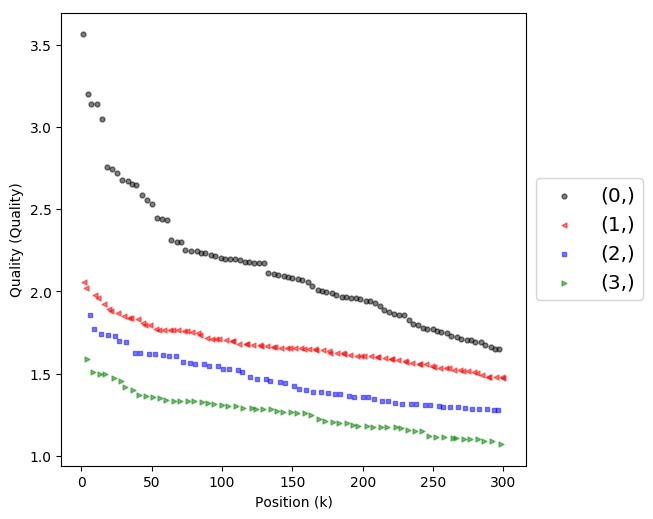

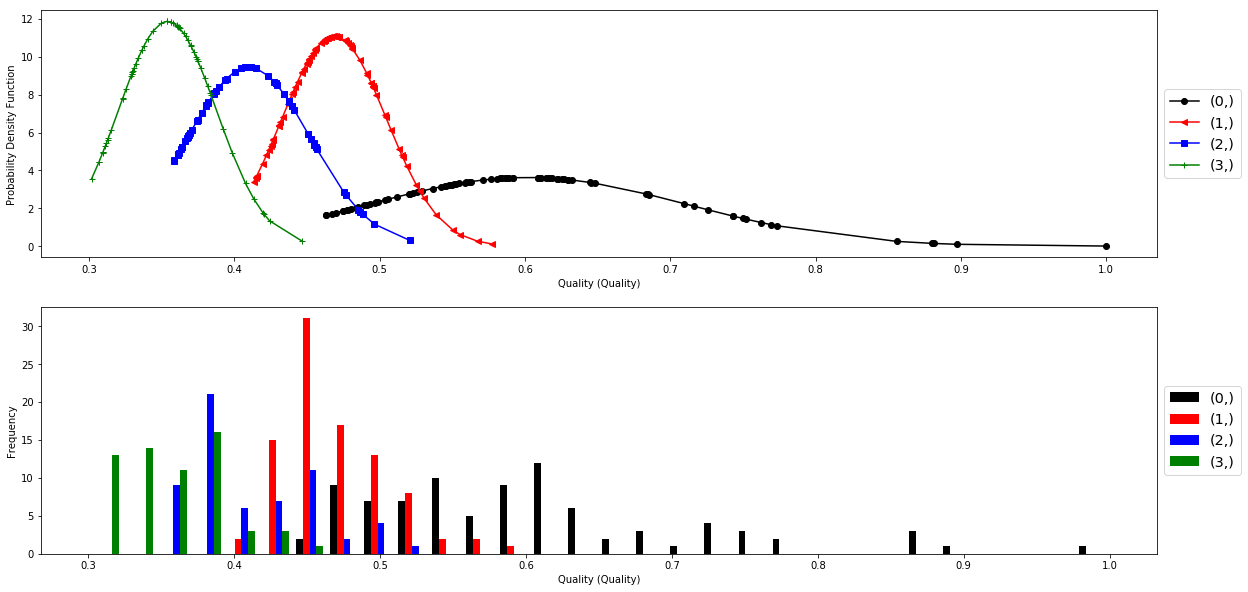

{'Quality': 1.0, 'k': 1, 'Utility': 1.4426950408889634, 'Group': 0, 'Index': 113}
{'Quality': 0.5774295529529241, 'k': 2, 'Utility': 0.52559902971134997, 'Group': 1, 'Index': 197}
{'Quality': 0.5674764832045397, 'k': 3, 'Utility': 0.40934775407014928, 'Group': 1, 'Index': 83}
{'Quality': 0.4466567918258464, 'k': 4, 'Utility': 0.27752346851971843, 'Group': 3, 'Index': 417}
{'Quality': 0.8973810048418225, 'k': 5, 'Utility': 0.50083787486745734, 'Group': 0, 'Index': 486}
{'Quality': 0.5209135672593572, 'k': 6, 'Utility': 0.26769661873249734, 'Group': 2, 'Index': 202}
{'Quality': 0.8814003593496779, 'k': 7, 'Utility': 0.42386397582384355, 'Group': 0, 'Index': 85}
{'Quality': 0.4243094610000255, 'k': 8, 'Utility': 0.19311155781555669, 'Group': 3, 'Index': 262}
{'Quality': 0.4965353593502506, 'k': 9, 'Utility': 0.21564256663566203, 'Group': 2, 'Index': 424}
{'Quality': 0.555524331875896, 'k': 10, 'Utility': 0.23167164061656156, 'Group': 1, 'Index': 438}
{'Quality': 0.8804091067147484, 'k': 1

{'Quality': 0.46882088075492645, 'k': 128, 'Utility': 0.096468925494770263, 'Group': 1, 'Index': 156}
{'Quality': 0.3606425152887017, 'k': 129, 'Utility': 0.07409141506023588, 'Group': 3, 'Index': 305}
{'Quality': 0.6090067602794474, 'k': 130, 'Utility': 0.12491940733991902, 'Group': 0, 'Index': 237}
{'Quality': 0.41110667202151374, 'k': 131, 'Utility': 0.084194828817416925, 'Group': 2, 'Index': 332}
{'Quality': 0.46800777210798966, 'k': 132, 'Utility': 0.095700278208596598, 'Group': 1, 'Index': 462}
{'Quality': 0.5919357409956633, 'k': 133, 'Utility': 0.12085649289745981, 'Group': 0, 'Index': 243}
{'Quality': 0.4085687616389805, 'k': 134, 'Utility': 0.083291717608742474, 'Group': 2, 'Index': 87}
{'Quality': 0.3604917834303009, 'k': 135, 'Utility': 0.073380237736013737, 'Group': 3, 'Index': 317}
{'Quality': 0.46683618522899173, 'k': 136, 'Utility': 0.094885771361077884, 'Group': 1, 'Index': 191}
{'Quality': 0.5915617580037063, 'k': 137, 'Utility': 0.12005912335825517, 'Group': 0, 'Inde

{'Quality': 0.3094652026611158, 'k': 282, 'Utility': 0.05481677682422377, 'Group': 3, 'Index': 453}
{'Quality': 0.361160930182858, 'k': 283, 'Utility': 0.063933895775814195, 'Group': 2, 'Index': 405}
{'Quality': 0.4745520049082452, 'k': 284, 'Utility': 0.08395451804928368, 'Group': 0, 'Index': 77}
{'Quality': 0.41950720773234784, 'k': 285, 'Utility': 0.074170405786273416, 'Group': 1, 'Index': 131}
{'Quality': 0.3069623737407843, 'k': 286, 'Utility': 0.054238596754665032, 'Group': 3, 'Index': 280}
{'Quality': 0.47038702560740403, 'k': 287, 'Utility': 0.083063801567640788, 'Group': 0, 'Index': 400}
{'Quality': 0.3611293986191676, 'k': 288, 'Utility': 0.063731416375116812, 'Group': 2, 'Index': 266}
{'Quality': 0.41547181077957823, 'k': 289, 'Utility': 0.07327699054412852, 'Group': 1, 'Index': 229}
{'Quality': 0.41537420646756096, 'k': 290, 'Utility': 0.07321532493505363, 'Group': 1, 'Index': 435}
{'Quality': 0.46716517039322897, 'k': 291, 'Utility': 0.082294421541861132, 'Group': 0, 'Inde

In [29]:
group_0=0
group_1=0
group_2=0
group_3=0
json_data = open('test_data_set_sample_500.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
minima = [h['Quality'] for h in data_set]    
lower_bound = min(minima)
for j in range(len(data_set)):
    data_set[j]['Index']=j+1  
    data_set[j]['Quality'] = data_set[j]['Quality']-lower_bound
    if(data_set[j]['Group']== 2):
        data_set[j]['Group']=3
    elif(data_set[j]['Group']==3):
        data_set[j]['Group']=2

    if(data_set[j]['Group']==0):
        group_0 = group_0+1
    elif(data_set[j]['Group']==1):
        group_1 = group_1+1    
    elif(data_set[j]['Group']==2):
        group_2 = group_2+1 
    elif(data_set[j]['Group']==3):
        group_3 = group_3+1     

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3

attribute = {"Group":4}  

p = [0.3,0.3,0.2,0.2]
k = 300
alpha = 0.1

test_ranking_syn, rest_syn = generate_ranking(data_set, attribute, 'Quality',k, p, alpha, False)

{'Quality': 1.6490620582000002, 'Group': 0, 'Index': 267}
1 :  [1, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.311873823302
{'Quality': 1.6372168171, 'Group': 0, 'Index': 2}
2 :  [2, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.0627222284955
{'Quality': 1.6308220219, 'Group': 0, 'Index': 61}
3 :  [3, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.0161021056552
{'Quality': 1.5975512094000002, 'Group': 0, 'Index': 362}
4 :  [4, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.00480206087844
{'Quality': 1.591126464, 'Group': 0, 'Index': 441}
5 :  [5, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.00159252460541
{'Quality': 1.5902873673000002, 'Group': 0, 'Index': 215}
6 :  [6, 0, 0, 0] Minimum Target:  [0.0, 0.0, 0.0]
CDF:  0.000548681620154
{'Quality': 1.4678796613, 'Group': 1, 'Index': 244}
Minimum achieved?  True
7 :  [6, 1, 0, 0] Minimum Target:  [1.0, 0.0, 0.0]
CDF:  0.00146941573241
{'Quality': 1.5807947181, 'Group': 0, 'Index': 9}
8 :  [7, 1, 0, 0] Minimum Target:

36 :  [14, 14, 4, 4] Minimum Target:  [7.0, 4.0, 4.0]
CDF:  0.00414373920514
{'Quality': 1.4201114299, 'Group': 0, 'Index': 292}
37 :  [15, 14, 4, 4] Minimum Target:  [8.0, 4.0, 4.0]
CDF:  0.00265737327187
{'Quality': 1.2618029696000002, 'Group': 2, 'Index': 271}
-------------------------------------------
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 2.0, 2.0], [3.0, 2.0, 2.0], [3.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [8.0, 4.0, 4.0], [8.0, 5.0, 5.0], [8.0, 5.0, 5.0], [8.0, 5.0, 5.0], [9.0, 5.0, 

67 :  [22, 27, 9, 9] Minimum Target:  [15.0, 9.0, 9.0]
CDF:  0.00440001167157
{'Quality': 1.2944666027, 'Group': 1, 'Index': 12}
68 :  [22, 28, 9, 9] Minimum Target:  [16.0, 9.0, 9.0]
CDF:  0.00368170984847
{'Quality': 1.2550900165, 'Group': 2, 'Index': 442}
-------------------------------------------
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 2.0, 2.0], [3.0, 2.0, 2.0], [3.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [4.0, 2.0, 2.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [5.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 3.0, 3.0], [6.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [7.0, 4.0, 4.0], [8.0, 4.0, 4.0], [8.0, 5.0, 5.0], [8.0, 5.0, 5.0], [8.0, 5.0, 5.0], [9.0, 5.0, 5.0],

108 :  [33, 29, 30, 16] Minimum Target:  [26.0, 16.0, 16.0]
CDF:  0.0109080842345
{'Quality': 0.9973536147000001, 'Group': 3, 'Index': 448}
Minimum achieved?  True
109 :  [33, 29, 30, 17] Minimum Target:  [27.0, 17.0, 17.0]
CDF:  0.0150130468271
{'Quality': 1.1081584625, 'Group': 2, 'Index': 127}
110 :  [33, 29, 31, 17] Minimum Target:  [27.0, 17.0, 17.0]
CDF:  0.0128023940778
{'Quality': 1.098460065, 'Group': 2, 'Index': 483}
111 :  [33, 29, 32, 17] Minimum Target:  [27.0, 17.0, 17.0]
CDF:  0.0107887941896
{'Quality': 1.0926750969, 'Group': 2, 'Index': 478}
112 :  [33, 29, 33, 17] Minimum Target:  [27.0, 17.0, 17.0]
CDF:  0.00899595752196
{'Quality': 1.0909715088, 'Group': 2, 'Index': 124}
113 :  [33, 29, 34, 17] Minimum Target:  [28.0, 17.0, 17.0]
CDF:  0.00743007599222
{'Quality': 1.0871060113, 'Group': 0, 'Index': 126}
114 :  [34, 29, 34, 17] Minimum Target:  [28.0, 17.0, 17.0]
CDF:  0.00592142680465
{'Quality': 0.9933259446, 'Group': 3, 'Index': 190}
Minimum achieved?  True
115 : 

145 :  [38, 36, 48, 23] Minimum Target:  [36.0, 23.0, 23.0]
CDF:  0.00400787757031
{'Quality': 0.5252071736885581, 'k': 26, 'Utility': 0.15935472386571339, 'Group': 1, 'Index': 46}
Minimum achieved?  True
146 :  [38, 37, 48, 23] Minimum Target:  [37.0, 23.0, 23.0]
CDF:  0.00496669157837
{'Quality': 0.9912273418, 'Group': 2, 'Index': 84}
147 :  [38, 37, 49, 23] Minimum Target:  [37.0, 23.0, 23.0]
CDF:  0.00406497729969
{'Quality': 0.9897081329, 'Group': 2, 'Index': 73}
148 :  [38, 37, 50, 23] Minimum Target:  [37.0, 23.0, 23.0]
CDF:  0.00331398879439
{'Quality': 0.5187433292528976, 'k': 30, 'Utility': 0.1510615207230139, 'Group': 1, 'Index': 57}
-------------------------------------------
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [2.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 1.0, 1.0], [3.0, 2.0, 2.

CDF:  0.014268754346
{'Quality': 0.49564264978064676, 'k': 59, 'Utility': 0.12105543201074642, 'Group': 1, 'Index': 315}
Minimum achieved?  True
182 :  [41, 47, 61, 33] Minimum Target:  [47.0, 30.0, 30.0]
CDF:  0.0173190695483
{'Quality': 0.8842888553, 'Group': 3, 'Index': 308}
183 :  [41, 47, 61, 34] Minimum Target:  [47.0, 30.0, 30.0]
CDF:  0.0199825289638
{'Quality': 0.8842443364, 'Group': 3, 'Index': 248}
184 :  [41, 47, 61, 35] Minimum Target:  [47.0, 30.0, 30.0]
CDF:  0.0225954770989
{'Quality': 0.4955843254709907, 'k': 63, 'Utility': 0.11916284144988339, 'Group': 1, 'Index': 443}
Minimum achieved?  True
185 :  [41, 48, 61, 35] Minimum Target:  [48.0, 30.0, 30.0]
CDF:  0.0273283176237
{'Quality': 0.8814003593496779, 'k': 7, 'Utility': 0.42386397582384355, 'Group': 0, 'Index': 85}
186 :  [42, 48, 61, 35] Minimum Target:  [48.0, 30.0, 30.0]
CDF:  0.0236465581422
{'Quality': 0.8804091067147484, 'k': 11, 'Utility': 0.35430268850938945, 'Group': 0, 'Index': 452}
187 :  [43, 48, 61, 35

{'Quality': 0.6268122946274481, 'k': 85, 'Utility': 0.14071922392639918, 'Group': 0, 'Index': 456}
255 :  [72, 67, 66, 50] Minimum Target:  [67.0, 43.0, 43.0]
CDF:  0.0264150955075
{'Quality': 0.6258223251377102, 'k': 88, 'Utility': 0.13942370768943715, 'Group': 0, 'Index': 145}
256 :  [73, 67, 66, 50] Minimum Target:  [67.0, 43.0, 43.0]
CDF:  0.0231666260128
{'Quality': 0.46882088075492645, 'k': 128, 'Utility': 0.096468925494770263, 'Group': 1, 'Index': 156}
Minimum achieved?  True
257 :  [73, 68, 66, 50] Minimum Target:  [68.0, 43.0, 43.0]
CDF:  0.0272588256051
{'Quality': 0.6228259562521422, 'k': 92, 'Utility': 0.13741032208845178, 'Group': 0, 'Index': 114}
258 :  [74, 68, 66, 50] Minimum Target:  [68.0, 43.0, 43.0]
CDF:  0.0239047429352
{'Quality': 0.6220009616670804, 'k': 95, 'Utility': 0.13627377570137847, 'Group': 0, 'Index': 226}
259 :  [75, 68, 66, 50] Minimum Target:  [68.0, 44.0, 44.0]
CDF:  0.0208952687105
{'Quality': 0.46800777210798966, 'k': 132, 'Utility': 0.095700278208

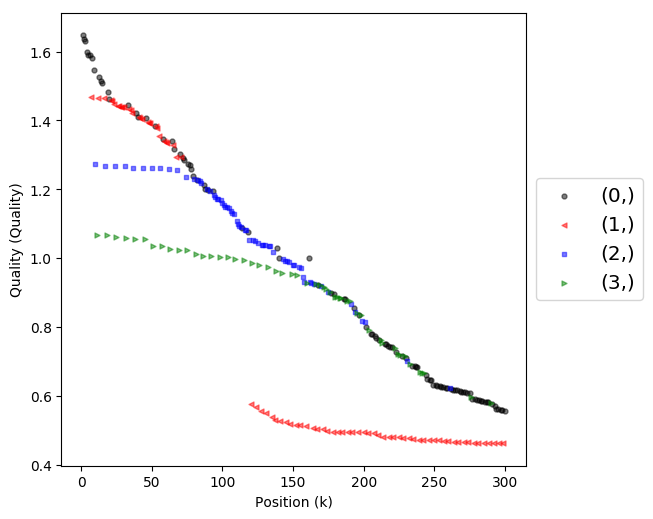

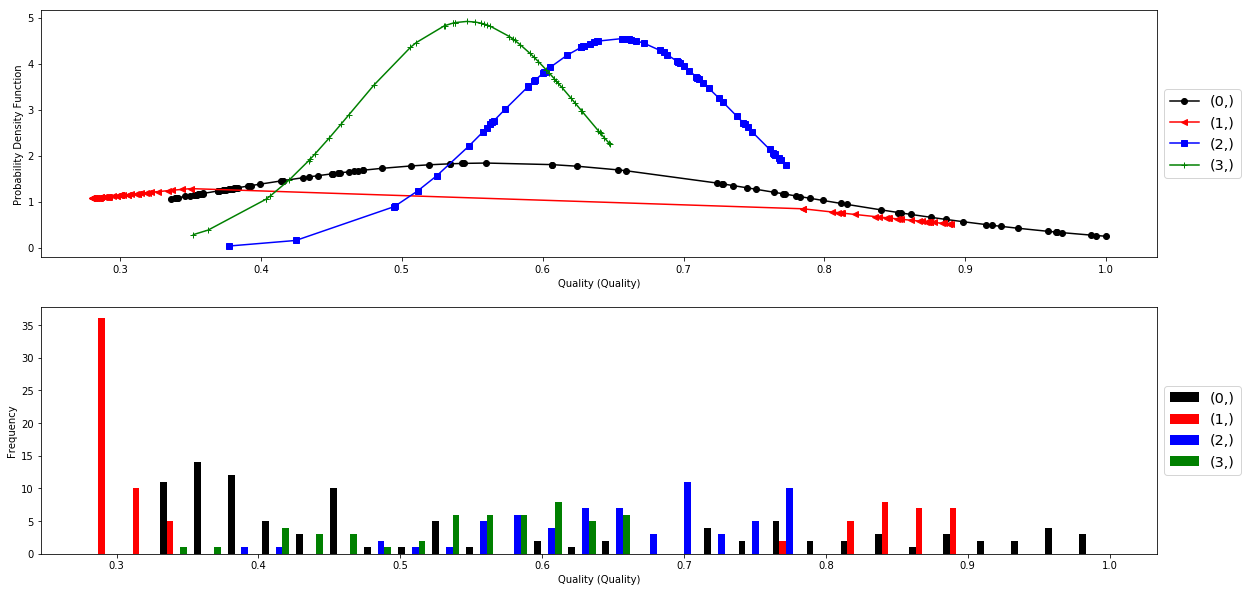

{'Quality': 1.0, 'k': 1, 'Utility': 1.4426950408889634, 'Group': 0, 'Index': 267}
{'Quality': 0.9928169828169295, 'k': 2, 'Utility': 0.90370096262127197, 'Group': 0, 'Index': 2}
{'Quality': 0.9889391450071262, 'k': 3, 'Utility': 0.71336880012137627, 'Group': 0, 'Index': 61}
{'Quality': 0.9687635474093524, 'k': 4, 'Utility': 0.60192663533332746, 'Group': 0, 'Index': 362}
{'Quality': 0.9648675476390266, 'k': 5, 'Utility': 0.53850283155178247, 'Group': 0, 'Index': 441}
{'Quality': 0.9643587149387487, 'k': 6, 'Utility': 0.49558234505684595, 'Group': 0, 'Index': 215}
{'Quality': 0.8901300311901141, 'k': 7, 'Utility': 0.4280620605814387, 'Group': 1, 'Index': 244}
{'Quality': 0.9586023219923475, 'k': 8, 'Utility': 0.43627871810650243, 'Group': 0, 'Index': 9}
{'Quality': 0.9373386361743168, 'k': 9, 'Utility': 0.40708099736522552, 'Group': 0, 'Index': 323}
{'Quality': 0.7730123937187799, 'k': 10, 'Utility': 0.32237120715312384, 'Group': 2, 'Index': 88}
{'Quality': 0.6478304803556604, 'k': 11, '

{'Quality': 0.5937161882607918, 'k': 126, 'Utility': 0.12256260496636516, 'Group': 3, 'Index': 330}
{'Quality': 0.3368729085200512, 'k': 127, 'Utility': 0.069429267790245622, 'Group': 1, 'Index': 438}
{'Quality': 0.629417666811734, 'k': 128, 'Utility': 0.12951480724787501, 'Group': 2, 'Index': 293}
{'Quality': 0.6290525462287905, 'k': 129, 'Utility': 0.12923432851510966, 'Group': 2, 'Index': 413}
{'Quality': 0.6287689724859622, 'k': 130, 'Utility': 0.12897303038251179, 'Group': 2, 'Index': 161}
{'Quality': 0.3338736135987362, 'k': 131, 'Utility': 0.068377464187997769, 'Group': 1, 'Index': 471}
{'Quality': 0.5910508892939369, 'k': 132, 'Utility': 0.12086067350141459, 'Group': 3, 'Index': 211}
{'Quality': 0.6272217651584314, 'k': 133, 'Utility': 0.12806089843214508, 'Group': 2, 'Index': 393}
{'Quality': 0.6272130660315983, 'k': 134, 'Utility': 0.12786502170858377, 'Group': 2, 'Index': 310}
{'Quality': 0.3268136529237347, 'k': 135, 'Utility': 0.066524854793411553, 'Group': 1, 'Index': 234

{'Quality': 0.39109988812929725, 'k': 248, 'Utility': 0.070884137203943043, 'Group': 0, 'Index': 318}
{'Quality': 0.3834325657768042, 'k': 249, 'Utility': 0.069444042343282303, 'Group': 0, 'Index': 227}
{'Quality': 0.2854198781777668, 'k': 250, 'Utility': 0.051655471745383277, 'Group': 1, 'Index': 222}
{'Quality': 0.38203797004331547, 'k': 251, 'Utility': 0.069091756851746802, 'Group': 0, 'Index': 74}
{'Quality': 0.3816580421586951, 'k': 252, 'Utility': 0.068973644984904658, 'Group': 0, 'Index': 175}
{'Quality': 0.28520599947499975, 'k': 253, 'Utility': 0.051506010965193728, 'Group': 1, 'Index': 195}
{'Quality': 0.3810799432168998, 'k': 254, 'Utility': 0.068771308224432171, 'Group': 0, 'Index': 196}
{'Quality': 0.3801023081639706, 'k': 255, 'Utility': 0.068546464377326116, 'Group': 0, 'Index': 456}
{'Quality': 0.37950198540181906, 'k': 256, 'Utility': 0.068390121093281964, 'Group': 0, 'Index': 145}
{'Quality': 0.28429547476621847, 'k': 257, 'Utility': 0.051197108572190599, 'Group': 1, 

In [30]:
test_ranking_binom, rest_binom = generate_ranking_from_binom(data_set, attribute, 'Quality',k, p, alpha, False)